In [23]:
import correctionlib
import pandas as pd
import numpy as np
import correctionlib.schemav2 as cs
import hist
import correctionlib.convert
import rich

import uproot

import requests

In [24]:
import sys

In [25]:
sys.path.insert(0, "/gwpool/users/gpizzati/test_processor/my_processor")

In [26]:
def get_cset(name, url):
    base_url = "https://raw.githubusercontent.com/latinos/LatinoAnalysis/UL_production/NanoGardener/python/data/trigger/"

    with open("test_sf.txt", "wb") as file:
        file.write(requests.get(base_url + url).content)
    columns = "eff stat_d stat_u syst_d syst_u"
    columns = columns.split(" ")
    df = pd.read_csv(
        "test_sf.txt",
        sep="\t",
        skiprows=0,
        header=None,
        names=["eta_l", "eta_h", "pt_l", "pt_h"] + columns,
    )
    for var in ["eta", "pt"]:
        df[var] = list(zip(df[var + "_l"], df[var + "_h"]))
        del df[var + "_l"]
        del df[var + "_h"]
    eta_bin = np.array(
        list(map(lambda k: k[0], np.unique(df["eta"]))) + [np.unique(df["eta"])[-1][-1]]
    )
    pt_bin = np.array(
        list(map(lambda k: k[0], np.unique(df["pt"]))) + [np.unique(df["pt"])[-1][-1]]
    )
    h = hist.Hist(
        hist.axis.StrCategory(columns, name="syst"),
        hist.axis.Variable(eta_bin, name="eta"),
        hist.axis.Variable(pt_bin, name="pt"),
        hist.storage.Double(),
    )
    for syst in columns:
        for pt_c in (pt_bin[1:] + pt_bin[:-1]) / 2:
            for eta_c in (eta_bin[1:] + eta_bin[:-1]) / 2:
                for i, (ipt, ieta) in enumerate(
                    list(zip(list(df["pt"]), list(df["eta"])))
                ):
                    if ieta[0] <= eta_c < ieta[1] and ipt[0] <= pt_c < ipt[1]:
                        h[hist.loc(syst), hist.loc(eta_c), hist.loc(pt_c)] = df[syst][i]
    h.name = name
    h.label = "out"
    cset = correctionlib.convert.from_histogram(h)
    return cset

In [27]:
def get_cset_drll(name, trigger_names, urls):
    base_url = "https://raw.githubusercontent.com/latinos/LatinoAnalysis/UL_production/NanoGardener/python/data/trigger/"

    for trigger_name, url in zip(trigger_names, urls):
        with open(f"test_sf_{trigger_name}.txt", "wb") as file:
            file.write(requests.get(base_url + url).content)
        with open(f"test_sf_{trigger_name}.txt") as file:
            lines = file.read().split("\n")
        lines = list(map(lambda k: k.strip(), lines))
        with open(f"test_sf_{trigger_name}.txt", "w") as file:
            file.write("\n".join(lines))

    big_df = {}
    for trigger_name in trigger_names:
        columns = "sf"
        columns = columns.split(" ")
        df = pd.read_csv(
            f"test_sf_{trigger_name}.txt",
            sep=" ",
            index_col=False,
            skiprows=0,
            header=None,
            names=["drll_l", "drll_h"] + columns,
        )
        for var in ["drll"]:
            df[var] = list(zip(df[var + "_l"], df[var + "_h"]))
            del df[var + "_l"]
            del df[var + "_h"]
        drll_bin = np.array(
            list(map(lambda k: k[0], np.unique(df["drll"])))
            + [np.unique(df["drll"])[-1][-1]]
        )
        big_df[trigger_name] = df

    h = hist.Hist(
        hist.axis.StrCategory(trigger_names, name="Trigger"),
        hist.axis.Variable(drll_bin, name="drll"),
        hist.storage.Double(),
    )

    for trigger in trigger_names:
        for drll_c in (drll_bin[1:] + drll_bin[:-1]) / 2:
            for i, (idrll) in enumerate(list(df["drll"])):
                if idrll[0] <= drll_c < idrll[1]:
                    h[hist.loc(trigger), hist.loc(drll_c)] = big_df[trigger]["sf"][i]
    h.name = name
    h.label = "out"
    cset = correctionlib.convert.from_histogram(h)
    return cset

In [28]:
from data.common.TrigMaker_cfg import Trigger

ModuleNotFoundError: No module named 'data'

DoubleEle
DoubleMu
MuEle
EleMu


📈 DRll_SF (v0)
No description
Node counts: Category: 1, Binning: 4
╭───────────────── ▶ input ─────────────────╮ ╭───── ▶ input ──────╮
│ Trigger (string)                          │ │ drll (real)        │
│ Trigger                                   │ │ drll               │
│ Values: DoubleEle, DoubleMu, EleMu, MuEle │ │ Range: [0.0, 20.0) │
╰───────────────────────────────────────────╯ ╰────────────────────╯
╭─── ◀ output ───╮
│ out (real)     │
│ No description │
╰────────────────╯

In [ ]:
for name, url in Trigger["Full2018v9"][1]["DRllSF"].items():
    csets.append(get_cset_drll("DRll_SF" + name, url))

In [ ]:
csets = []
for name, url in Trigger["Full2018v9"][1]["LegEffData"].items():
    csets.append(get_cset("LegEffData_" + name, url))
for name, url in Trigger["Full2018v9"][1]["LegEffMC"].items():
    csets.append(get_cset("LegEffMC_" + name, url))

csets.append(
    get_cset_drll(
        "DRll_SF",
        list(Trigger["Full2018v9"][1]["DRllSF"].keys()),
        list(Trigger["Full2018v9"][1]["DRllSF"].values()),
    )
)

In [ ]:
cset = correctionlib.schemav2.CorrectionSet(
    schema_version=2, description="", corrections=csets
)

In [ ]:
rich.print(cset)

CorrectionSet (schema v2)
No description
📂
├── 📈 Data_DoubleEleLegHigPt (v0)
│   No description
│   Node counts: Category: 1, MultiBinning: 5
│   ╭────────────────── ▶ input ──────────────────╮ ╭───── ▶ input ──────╮ ╭────── ▶ input ──────╮
│   │ syst (string)                               │ │ eta (real)         │ │ pt (real)           │
│   │ syst                                        │ │ eta                │ │ pt                  │
│   │ Values: eff, stat_d, stat_u, syst_d, syst_u │ │ Range: [-2.5, 2.5) │ │ Range: [0.0, 200.0) │
│   ╰─────────────────────────────────────────────╯ ╰────────────────────╯ ╰─────────────────────╯
│   ╭─── ◀ output ───╮
│   │ out (real)     │
│   │ No description │
│   ╰────────────────╯
├── 📈 Data_DoubleEleLegLowPt (v0)
│   No description
│   Node counts: Category: 1, MultiBinning: 5
│   ╭────────────────── ▶ input ──────────────────╮ ╭───── ▶ input ──────╮ ╭────── ▶ input ──────╮
│   │ syst (string)                               │ │ eta (real)         │ │ pt (real)           │
│   │ syst                                        │ │ eta                │ │ pt                  │
│   │ Values: eff, stat_d, stat_u, syst_d, syst_u │ │ Range: [-2.5, 2.5) │ │ Range: [0.0, 200.0) │
│   ╰─────────────────────────────────────────────╯ ╰────────────────────╯ ╰─────────────────────╯
│   ╭─── ◀ output ───╮
│   │ out (real)     │
│   │ No description │
│   ╰────────────────╯
├── 📈 Data_SingleEle (v0)
│   No description
│   Node counts: Category: 1, MultiBinning: 5
│   ╭────────────────── ▶ input ──────────────────╮ ╭───── ▶ input ──────╮ ╭────── ▶ input ──────╮
│   │ syst (string)                               │ │ eta (real)         │ │ pt (real)           │
│   │ syst                                        │ │ eta                │ │ pt                  │
│   │ Values: eff, stat_d, stat_u, syst_d, syst_u │ │ Range: [-2.5, 2.5) │ │ Range: [0.0, 200.0) │
│   ╰─────────────────────────────────────────────╯ ╰────────────────────╯ ╰─────────────────────╯
│   ╭─── ◀ output ───╮
│   │ out (real)     │
│   │ No description │
│   ╰────────────────╯
├── 📈 Data_DoubleMuLegHigPt (v0)
│   No description
│   Node counts: Category: 1, MultiBinning: 5
│   ╭────────────────── ▶ input ──────────────────╮ ╭───── ▶ input ──────╮ ╭────── ▶ input ──────╮
│   │ syst (string)                               │ │ eta (real)         │ │ pt (real)           │
│   │ syst                                        │ │ eta                │ │ pt                  │
│   │ Values: eff, stat_d, stat_u, syst_d, syst_u │ │ Range: [-2.4, 2.4) │ │ Range: [0.0, 200.0) │
│   ╰─────────────────────────────────────────────╯ ╰────────────────────╯ ╰─────────────────────╯
│   ╭─── ◀ output ───╮
│   │ out (real)     │
│   │ No description │
│   ╰────────────────╯
├── 📈 Data_DoubleMuLegLowPt (v0)
│   No description
│   Node counts: Category: 1, MultiBinning: 5
│   ╭────────────────── ▶ input ──────────────────╮ ╭───── ▶ input ──────╮ ╭────── ▶ input ──────╮
│   │ syst (string)                               │ │ eta (real)         │ │ pt (real)           │
│   │ syst                                        │ │ eta                │ │ pt                  │
│   │ Values: eff, stat_d, stat_u, syst_d, syst_u │ │ Range: [-2.4, 2.4) │ │ Range: [0.0, 200.0) │
│   ╰─────────────────────────────────────────────╯ ╰────────────────────╯ ╰─────────────────────╯
│   ╭─── ◀ output ───╮
│   │ out (real)     │
│   │ No description │
│   ╰────────────────╯
├── 📈 Data_SingleMu (v0)
│   No description
│   Node counts: Category: 1, MultiBinning: 5
│   ╭────────────────── ▶ input ──────────────────╮ ╭───── ▶ input ──────╮ ╭────── ▶ input ──────╮
│   │ syst (string)                               │ │ eta (real)         │ │ pt (real)           │
│   │ syst                                        │ │ eta                │ │ pt                  │
│   │ Values: eff, stat_d, stat_u, syst_d, syst_u │ │ Range: [-2.4, 2.4) │ │ Range: [0.0, 200.0) │
│   ╰─────────────────────────────────────────────╯

In [ ]:
csets[1]

In [ ]:
rich.print(cset)

📈 DoubleEleLegHigPt (v0)
No description
Node counts: Category: 1, MultiBinning: 5
╭────────────────── ▶ input ──────────────────╮ ╭───── ▶ input ──────╮ ╭────── ▶ input ──────╮
│ syst (string)                               │ │ eta (real)         │ │ pt (real)           │
│ syst                                        │ │ eta                │ │ pt                  │
│ Values: eff, stat_d, stat_u, syst_d, syst_u │ │ Range: [-2.5, 2.5) │ │ Range: [0.0, 200.0) │
╰─────────────────────────────────────────────╯ ╰────────────────────╯ ╰─────────────────────╯
╭─── ◀ output ───╮
│ out (real)     │
│ No description │
╰────────────────╯

In [ ]:
ceval = cset.to_evaluator()
vpt = 100.0
veta = -2.3
syst = "eff"
print(ceval.evaluate(syst, veta, vpt))
for i, (ipt, ieta) in enumerate(list(zip(list(df["pt"]), list(df["eta"])))):
    if ieta[0] <= veta < ieta[1] and ipt[0] <= vpt < ipt[1]:
        print(i)
        print(df[syst][i])

0.985
12
0.985


In [ ]:
cset = correctionlib.convert.from_txt("test_sf.root:h_Ele_signal_pt_eta_bin")

In [ ]:
url_base = "https://github.com/latinos/LatinoAnalysis/raw/UL_production/NanoGardener/python/data/"
url = "fake_prompt_rates/Full2018v9/mvaFall17V2Iso_WP90/ElePR.root"
with open("test_sf.root", "wb") as file:
    file.write(requests.get(url_base + url).content)

cset = correctionlib.convert.from_uproot_THx("test_sf.root:h_Ele_signal_pt_eta_bin")

ceval = cset.to_evaluator()

ceval.evaluate(17.0, 0.0)

0.8799667219594568

In [ ]:
fname = "root://ccxrdcms.in2p3.fr:1094/pnfs/in2p3.fr/data/cms/disk/data//store/mc/RunIISummer20UL18NanoAODv9/EWK_LLJJ_MLL-50_MJJ-120_TuneCP5_13TeV-madgraph-pythia8_dipole/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/40000/3BF5756A-131F-8C4C-9CFC-71B15EDB9351.root"
events = read_events(fname, stop=10_000, read_form=forms["mc"])

start reading
created events


In [2]:
import gzip
import json
import correctionlib
import correctionlib.convert
import numpy as np
import hist
import uproot
import rich
import requests
import pandas as pd

In [3]:
fname = '/cvmfs/cms.cern.ch/rsync/cms-nanoAOD/jsonpog-integration/POG/EGM/2018_UL/electron.json.gz'

In [4]:
ceval = correctionlib.CorrectionSet.from_file(
fname
)

## Explore correctionlib json file

In [5]:
with gzip.open(fname) as file:
    corr = json.load(file)

In [6]:
def find_key(key: str, l: list):
    for i in range(len(l)):
        if l[i]["key"] == key:
            return i


def print_keys(l: list):
    for i in range(len(l)):
        print(l[i]["key"])

In [12]:
corr["corrections"][0]["data"]["content"][0]["value"]["input"]

'ValType'

In [13]:
real_content = corr["corrections"][0]["data"]["content"][0]["value"]["content"]

In [14]:
print_keys(real_content)

sf
sfup
sfdown


In [15]:
find_key("sf", real_content)

0

In [16]:
sf = real_content[0]["value"]
sf["input"], sf.keys()

('WorkingPoint', dict_keys(['nodetype', 'input', 'content']))

In [17]:
print_keys(sf["content"])

RecoBelow20
RecoAbove20
Veto
Loose
Medium
Tight
wp80iso
wp80noiso
wp90iso
wp90noiso


In [18]:
find_key("RecoBelow20", sf["content"])

0

# Electron SF

In [7]:
def get_cset_electron(era, wp, return_histo=False):
    real_content = corr["corrections"][0]["data"]["content"][0]["value"]["content"]
    content_syst = []
    for valType in ["sf", "sfdown", "sfup"]:
        sf_ind = find_key(valType, real_content)
        sf = real_content[sf_ind]["value"]["content"]

        wp_ind = find_key(wp, sf)
        obj = sf[wp_ind]["value"]
        content = np.array(obj["content"])
        content_syst.append(content)
        axis = [
            hist.axis.Variable(edges, name=name)
            for edges, name in zip(obj["edges"], obj["inputs"])
        ]
    content_syst = np.array(content_syst)
    shape = [ax.edges.shape[0] - 1 for ax in axis]
    content_syst = content_syst.reshape(3, *shape)
    syst = ["nominal", "syst_down", "syst_up"]
    # syst = ['sf', 'sfdown', 'sfup']
    h = hist.Hist(
        hist.axis.StrCategory(syst, name="syst"),
        *axis,
        hist.storage.Double(),
        data=content_syst,
    )
    h.name = "Electron_RecoSF_" + wp
    h.label = "out"
    cset = correctionlib.convert.from_histogram(h)
    # a = h.view()
    # print(a.shape)
    # print(content.shape)
    # a[:, :] = content.reshape(a.shape)
    if return_histo:
        return h, cset
    return cset

In [8]:
def rand_in_axis(axis):
    min = axis[0] if axis[0] > -np.inf else axis[1] - (axis[2] - axis[1]) / 2
    max = axis[-1] if axis[-1] < np.inf else axis[-2] + (axis[-2] - axis[-3]) / 2
    return np.random.uniform(min, max)

In [9]:
def rand_in_histos(h, nrands=10):
    result = []
    for i in range(nrands):
        r = []
        for j in range(len(h.axes)):
            r.append(rand_in_axis(h.axes[j].edges))
        result.append(r)
    return result

In [10]:
def different_val(a, b):
    precision = 1e-10
    if a == b:
        return False
    if abs(a) < precision and abs(b) < precision:
        return False
    d = abs(a - b)
    if d < precision:
        return False
    return True

In [11]:
for wp in ['RecoBelow20', 'RecoAbove20']:
    valTypes = ["sf", "sfdown", "sfup"]
    systs = ["nominal", "syst_down", "syst_up"]
    h, cset = get_cset_electron("2018", wp, return_histo=True)
    ceval_new = cset.to_evaluator()
    l = [h.axes[i].centers for i in range(1, len(h.axes))]
    rand_inputs = np.transpose([np.tile(l[0], len(l[1])), np.repeat(l[1], len(l[0]))])
    rand_inputs[rand_inputs == np.inf] = 100
    rand_inputs[rand_inputs == -np.inf] = -100
    # rand_inputs = rand_in_histos(h, nrands=100)
    for syst, valType in zip(systs, valTypes):
        for eta, pt in rand_inputs:
            # new_val = h[hist.loc(syst), hist.loc(eta), hist.loc(pt)]
            new_val = ceval_new.evaluate(syst, eta, pt)
            old_val = ceval["UL-Electron-ID-SF"].evaluate("2018", valType, wp, eta, pt)
            if different_val(new_val, old_val):
                raise Exception("Different values for eta", eta, "pt", pt, old_val, new_val)
    print("Everything ok for", wp)

Everything ok for RecoBelow20
Everything ok for RecoAbove20


In [12]:
csets = []
for wp in ["RecoBelow20", "RecoAbove20"]:
    csets.append(get_cset_electron("2018", wp))
    rich.print(csets[-1])

📈 Electron_RecoSF_RecoBelow20 (v0)
No description
Node counts: Category: 1, MultiBinning: 3
╭────────────── ▶ input ──────────────╮ ╭───── ▶ input ──────╮ ╭────── ▶ input ──────╮
│ syst (string)                       │ │ eta (real)         │ │ pt (real)           │
│ syst                                │ │ eta                │ │ pt                  │
│ Values: nominal, syst_down, syst_up │ │ Range: [-inf, inf) │ │ Range: [10.0, 20.0) │
╰─────────────────────────────────────╯ ╰────────────────────╯ ╰─────────────────────╯
╭─── ◀ output ───╮
│ out (real)     │
│ No description │
╰────────────────╯

📈 Electron_RecoSF_RecoAbove20 (v0)
No description
Node counts: Category: 1, MultiBinning: 3
╭────────────── ▶ input ──────────────╮ ╭───── ▶ input ──────╮ ╭───── ▶ input ──────╮
│ syst (string)                       │ │ eta (real)         │ │ pt (real)          │
│ syst                                │ │ eta                │ │ pt                 │
│ Values: nominal, syst_down, syst_up │ │ Range: [-inf, inf) │ │ Range: [20.0, inf) │
╰─────────────────────────────────────╯ ╰────────────────────╯ ╰────────────────────╯
╭─── ◀ output ───╮
│ out (real)     │
│ No description │
╰────────────────╯

In [13]:
def get_cset_electron_wp():
    with open("test_sf.txt", "w") as file:
        file.write(
            requests.get(
                "https://raw.githubusercontent.com/latinos/LatinoAnalysis/UL_production/NanoGardener/python/data/scale_factor/Full2018v9/egammaEffi_TightHWW_2018.txt"
            ).text
        )
    columns = "effData statErrData systErrData effMC statErrMC systErrMC effDataAltBkg effDataAltSig effMCAltMC effMCTagSel"
    columns = columns.split(" ")
    df = pd.read_csv(
        "test_sf.txt",
        sep="\t",
        skiprows=3,
        header=None,
        names=["eta_l", "eta_h", "pt_l", "pt_h"] + columns,
    )
    df
    for var in ["eta", "pt"]:
        df[var] = list(zip(df[var + "_l"], df[var + "_h"]))
        del df[var + "_l"]
        del df[var + "_h"]

    df["sf"] = df["effData"] / df["effMC"]
    df["sf_err"] = (
        np.sqrt(
            (df["statErrData"] / df["effData"]) ** 2
            + (df["statErrMC"] / df["effMC"]) ** 2
        )
        * df["sf"]
    )
    df["sf_syst"] = (
        np.sqrt(
            (df["systErrData"] / df["effData"]) ** 2
            + (df["systErrMC"] / df["effMC"]) ** 2
        )
        * df["sf"]
    )
    eta_bin = np.array(
        list(map(lambda k: k[0], np.unique(df["eta"]))) + [np.unique(df["eta"])[-1][-1]]
    )
    pt_bin = np.array(
        list(map(lambda k: k[0], np.unique(df["pt"]))) + [np.unique(df["pt"])[-1][-1]]
    )
    h = hist.Hist(
        hist.axis.StrCategory(["nominal", "stat", "syst"], name="syst"),
        hist.axis.Variable(eta_bin, name="eta"),
        hist.axis.Variable(pt_bin, name="pt"),
        hist.storage.Double(),
    )
    for syst, sf_name in zip(["nominal", "stat", "syst"], ["sf", "sf_err", "sf_syst"]):
        for pt_c in (pt_bin[1:] + pt_bin[:-1]) / 2:
            for eta_c in (eta_bin[1:] + eta_bin[:-1]) / 2:
                for i, (ipt, ieta) in enumerate(
                    list(zip(list(df["pt"]), list(df["eta"])))
                ):
                    if ieta[0] <= eta_c < ieta[1] and ipt[0] <= pt_c < ipt[1]:
                        # print(i)
                        # print(df['sf'][i], df['sf_err'][i])
                        h[hist.loc(syst), hist.loc(eta_c), hist.loc(pt_c)] = df[
                            sf_name
                        ][i]

    h.name = "Electron_WP_SF"
    h.label = "out"
    return correctionlib.convert.from_histogram(h)

In [14]:
csets.append(get_cset_electron_wp())
rich.print(csets[-1])

📈 Electron_WP_SF (v0)
No description
Node counts: Category: 1, MultiBinning: 3
╭────────── ▶ input ──────────╮ ╭───── ▶ input ──────╮ ╭────── ▶ input ───────╮
│ syst (string)               │ │ eta (real)         │ │ pt (real)            │
│ syst                        │ │ eta                │ │ pt                   │
│ Values: nominal, stat, syst │ │ Range: [-2.5, 2.5) │ │ Range: [10.0, 500.0) │
╰─────────────────────────────╯ ╰────────────────────╯ ╰──────────────────────╯
╭─── ◀ output ───╮
│ out (real)     │
│ No description │
╰────────────────╯

# Muons SF

In [15]:
corrections = {
    "Muon_IdSF": "NUM_TightHWW_DEN_TrackerMuons_eta_pt",
    "Muon_IsoSF": "NUM_TightHWW_ISO_DEN_TightHWW_eta_pt",
}

In [16]:
def get_muon_cset(corrName, histoName):
    url = f"https://github.com/latinos/LatinoAnalysis/raw/UL_production/NanoGardener/python/data/scale_factor/Full2018v9/{histoName}.root"
    with open("test_sf.root", "wb") as file:
        file.write(requests.get(url).content)
    f = uproot.open("test_sf.root")
    h = f[histoName].to_hist()
    axis = [
        hist.axis.Variable(axis.edges, name=name)
        for axis, name in zip(h.axes, ["eta", "pt"])
    ]
    data = np.array([h.values(), np.sqrt(h.variances())])
    h_sf = hist.Hist(
        hist.axis.StrCategory(["nominal", "syst"], name="syst"), *axis, data=data
    )
    h_sf.name = corrName
    h_sf.label = "out"
    cset = correctionlib.convert.from_histogram(h_sf)
    return cset

In [17]:
for corrName, histoName in corrections.items():
    csets.append(get_muon_cset(corrName, histoName))
    rich.print(csets[-1])

📈 Muon_IdSF (v0)
No description
Node counts: Category: 1, MultiBinning: 2
╭─────── ▶ input ───────╮ ╭───── ▶ input ──────╮ ╭────── ▶ input ───────╮
│ syst (string)         │ │ eta (real)         │ │ pt (real)            │
│ syst                  │ │ eta                │ │ pt                   │
│ Values: nominal, syst │ │ Range: [-2.4, 2.4) │ │ Range: [10.0, 200.0) │
╰───────────────────────╯ ╰────────────────────╯ ╰──────────────────────╯
╭─── ◀ output ───╮
│ out (real)     │
│ No description │
╰────────────────╯

📈 Muon_IsoSF (v0)
No description
Node counts: Category: 1, MultiBinning: 2
╭─────── ▶ input ───────╮ ╭───── ▶ input ──────╮ ╭────── ▶ input ───────╮
│ syst (string)         │ │ eta (real)         │ │ pt (real)            │
│ syst                  │ │ eta                │ │ pt                   │
│ Values: nominal, syst │ │ Range: [-2.4, 2.4) │ │ Range: [10.0, 200.0) │
╰───────────────────────╯ ╰────────────────────╯ ╰──────────────────────╯
╭─── ◀ output ───╮
│ out (real)     │
│ No description │
╰────────────────╯

# Save everything

In [18]:
cset = correctionlib.schemav2.CorrectionSet(
    schema_version=2, description="", corrections=csets
)

In [19]:
rich.print(cset)

CorrectionSet (schema v2)
No description
📂
├── 📈 Electron_RecoSF_RecoBelow20 (v0)
│   No description
│   Node counts: Category: 1, MultiBinning: 3
│   ╭────────────── ▶ input ──────────────╮ ╭───── ▶ input ──────╮ ╭────── ▶ input ──────╮
│   │ syst (string)                       │ │ eta (real)         │ │ pt (real)           │
│   │ syst                                │ │ eta                │ │ pt                  │
│   │ Values: nominal, syst_down, syst_up │ │ Range: [-inf, inf) │ │ Range: [10.0, 20.0) │
│   ╰─────────────────────────────────────╯ ╰────────────────────╯ ╰─────────────────────╯
│   ╭─── ◀ output ───╮
│   │ out (real)     │
│   │ No description │
│   ╰────────────────╯
├── 📈 Electron_RecoSF_RecoAbove20 (v0)
│   No description
│   Node counts: Category: 1, MultiBinning: 3
│   ╭────────────── ▶ input ──────────────╮ ╭───── ▶ input ──────╮ ╭───── ▶ input ──────╮
│   │ syst (string)                       │ │ eta (real)         │ │ pt (real)          │
│   │ syst                                │ │ eta                │ │ pt                 │
│   │ Values: nominal, syst_down, syst_up │ │ Range: [-inf, inf) │ │ Range: [20.0, inf) │
│   ╰─────────────────────────────────────╯ ╰────────────────────╯ ╰────────────────────╯
│   ╭─── ◀ output ───╮
│   │ out (real)     │
│   │ No description │
│   ╰────────────────╯
├── 📈 Electron_WP_SF (v0)
│   No description
│   Node counts: Category: 1, MultiBinning: 3
│   ╭────────── ▶ input ──────────╮ ╭───── ▶ input ──────╮ ╭────── ▶ input ───────╮
│   │ syst (string)               │ │ eta (real)         │ │ pt (real)            │
│   │ syst                        │ │ eta                │ │ pt                   │
│   │ Values: nominal, stat, syst │ │ Range: [-2.5, 2.5) │ │ Range: [10.0, 500.0) │
│   ╰─────────────────────────────╯ ╰────────────────────╯ ╰──────────────────────╯
│   ╭─── ◀ output ───╮
│   │ out (real)     │
│   │ No description │
│   ╰────────────────╯
├── 📈 Muon_IdSF (v0)
│   No description
│   Node counts: Category: 1, MultiBinning: 2
│   ╭─────── ▶ input ───────╮ ╭───── ▶ input ──────╮ ╭────── ▶ input ───────╮
│   │ syst (string)         │ │ eta (real)         │ │ pt (real)            │
│   │ syst                  │ │ eta                │ │ pt                   │
│   │ Values: nominal, syst │ │ Range: [-2.4, 2.4) │ │ Range: [10.0, 200.0) │
│   ╰───────────────────────╯ ╰────────────────────╯ ╰──────────────────────╯
│   ╭─── ◀ output ───╮
│   │ out (real)     │
│   │ No description │
│   ╰────────────────╯
└── 📈 Muon_IsoSF (v0)
    No description
    Node counts: Category: 1, MultiBinning: 2
    ╭─────── ▶ input ───────╮ ╭───── ▶ input ──────╮ ╭────── ▶ input ───────╮
    │ syst (string)         │ │ eta (real)         │ │ pt (real)            │
    │ syst                  │ │ eta                │ │ pt                   │
    │ Values: nominal, syst │ │ Range: [-2.4, 2.4) │ │ Range: [10.0, 200.0) │
    ╰───────────────────────╯ ╰────────────────────╯ ╰──────────────────────╯
    ╭─── ◀ output ───╮
    │ out (real)     │
    │ No description │
    ╰────────────────╯

In [20]:
import os

os.makedirs("../data/2018/", exist_ok=True)
with gzip.open("../data/2018/lepton_sf.json.gz", "wt") as fout:
    fout.write(cset.json(exclude_unset=True))

In [72]:
ceval_lepton_sf = correctionlib.CorrectionSet.from_file(
    "../data/2018/lepton_sf.json.gz"
)

In [141]:
import uproot
import awkward as ak
import os
import sys
sys.path.insert(0, os.path.dirname(os.path.abspath('.')))
from framework import read_events
import json
with open('../data/common/forms.json') as file:
    forms = json.load(file)
events = read_events('/Users/giorgiopizzati/testcoffea/rootFiles/7B930101-EB91-4F4E-9B90-0861460DBD94.root', 0, 100_000, forms['mc'])

start reading
created events


In [142]:
with open('../data/cfg.json') as file:
    cfg = json.load(file)

In [143]:
from modules.lepton_sel import createLepton, leptonSel


events = createLepton(events)
events = leptonSel(events)
events["Lepton"] = events.Lepton[events.Lepton.isLoose]
events = events[ak.num(events.Lepton) >= 2]
events = events[events.Lepton[:, 0].pt >= 8]

In [144]:
import modules.lepton_sf

In [145]:
from modules.lepton_sf import lepton_sf

In [146]:
import importlib

In [147]:
importlib.reload(modules.lepton_sf)

<module 'modules.lepton_sf' from '/Users/giorgiopizzati/development/cern/my_processor/modules/lepton_sf.py'>

In [148]:
events, _ = modules.lepton_sf.lepton_sf(events, {}, ceval_lepton_sf, cfg)

[[True, True], [True, True], [True, ...], ..., [False, False], [True, True]]
[[0.967, 0.955], [0.955, 0.967], [...], ..., [None, None], [0.957, 0.963]]
[[True, True], [True, True], [True, ...], ..., [False, False], [True, True]]
[[0.00197, 0.00174], [0.00174, 0.00197], ..., [None, ...], [0.00165, 0.00178]]
[[True, True], [True, True], [True, ...], ..., [False, False], [True, True]]
[[0.00708, 0.00641], [0.00641, 0.00708], ..., [None, ...], [0.018, 0.00653]]
[[False, False], [False, False], [...], ..., [True, True], [False, False]]
[[None, None], [None, None], [None, ...], ..., [0.993, 0.994], [None, None]]
[[False, False], [False, False], [...], ..., [True, True], [False, False]]
[[None, None], [None, None], [...], ..., [0.000593, 0.000707], [None, None]]
[[False, False], [False, False], [...], ..., [True, True], [False, False]]
[[None, None], [None, None], [None, ...], ..., [0.999, 0.993], [None, None]]
[[False, False], [False, False], [...], ..., [True, True], [False, False]]
[[None,

In [149]:
events.Lepton.pdgId

<Array [[11, -11], [-11, 11], ..., [...], [11, -11]] type='23275 * var * int32'>

In [150]:
events.Lepton.TightSF[events.Lepton['isTightMuon_'+ cfg['muWP']]]

<Array [[], [], [], ..., [0.992, 0.987], []] type='23275 * var * ?float64'>

In [151]:
events.Lepton.TightSF[events.Lepton['isTightElectron_'+ cfg['eleWP']]]

<Array [[0.967, 0.955], ..., [0.957, 0.963]] type='23275 * var * ?float64'>

In [152]:
h = hist.Hist(
    hist.axis.StrCategory(['weight', 'reco_sf', 'tight_sf'], name='syst'),
    hist.axis.StrCategory(['e', 'm'], name='cat'),
    hist.axis.Regular(30, 10, 100, name='pt'),
    hist.storage.Weight())

In [153]:
events = events[ak.num(events.Lepton) >= 2]
events['weight'] = events.genWeight
events['reco_sf'] = events.weight * events.Lepton.RecoSF[:, 0] * events.Lepton.RecoSF[:, 1]
events['tight_sf'] = events.reco_sf * events.Lepton.TightSF[:, 0] * events.Lepton.TightSF[:, 1]
events['e'] = abs(events.Lepton[:, 0].pdgId) == 11
events['m'] = abs(events.Lepton[:, 0].pdgId) == 13


In [154]:
for variation in ['weight', 'reco_sf', 'tight_sf']:
    for cat in ['e', 'm']:
        mask = events[cat]
        h.fill(syst=variation, cat=cat, pt=events.Lepton.pt[:, 0][mask], weight=events[variation][mask])

In [155]:
ax_ind = 2
x = h.axes[ax_ind].centers
edges = h.axes[ax_ind].edges

In [156]:
import matplotlib.pyplot as plt

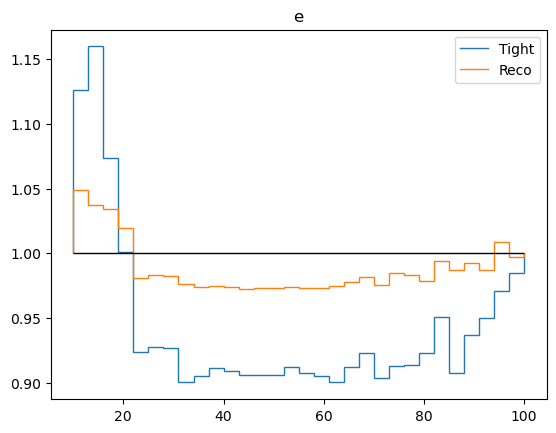

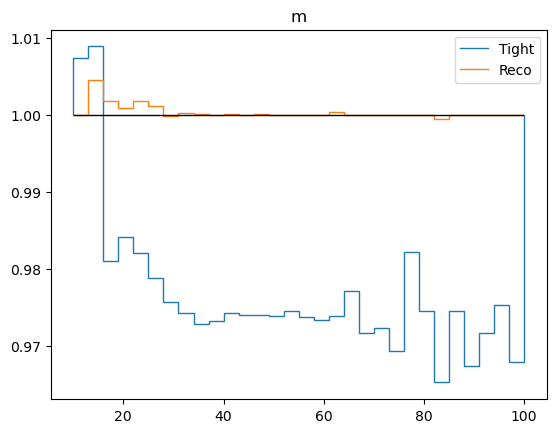

In [157]:
for cat in ['e', 'm']:
    values = []
    for variation in ['weight', 'reco_sf', 'tight_sf']:
        values.append(h[hist.loc(variation), hist.loc(cat), :].values())
    plt.figure()
    plt.title(cat)
    plt.stairs(values[2]/values[0], edges, baseline=1.0, label='Tight')
    plt.stairs(values[1]/values[0], edges, baseline=1.0, label='Reco')
    plt.stairs(np.ones_like(x), edges, baseline=1, color='black')
    plt.legend()

In [ ]:
ceval = cset.to_evaluator()
veta = 1.5
vpt = 15.0
point = h[hist.loc(veta), hist.loc(vpt)]
print(point.value, np.sqrt(point.variance))
args = (veta, vpt)
print(ceval.evaluate("nominal", *args), ceval.evaluate("syst", *args))

0.9943716526031494 0.0020353191106662998
0.9943716526031494 0.0020353191106663


In [ ]:
cset_muon = cset

In [ ]:
eta_bin = np.array(
    list(map(lambda k: k[0], np.unique(df["eta"]))) + [np.unique(df["eta"])[-1][-1]]
)
pt_bin = np.array(
    list(map(lambda k: k[0], np.unique(df["pt"]))) + [np.unique(df["pt"])[-1][-1]]
)
print(eta_bin)
print(pt_bin)

[-2.5   -2.    -1.566 -1.442 -0.8    0.     0.8    1.442  1.566  2.
  2.5  ]
[ 10.  15.  20.  35.  50.  90. 150. 500.]


In [ ]:
h = hist.Hist(
    hist.axis.StrCategory(["nominal", "stat", "syst"], name="syst"),
    hist.axis.Variable(eta_bin, name="eta"),
    hist.axis.Variable(pt_bin, name="pt"),
    hist.storage.Double(),
)

In [ ]:
for syst, sf_name in zip(["nominal", "stat", "syst"], ["sf", "sf_err", "sf_syst"]):
    for pt_c in (pt_bin[1:] + pt_bin[:-1]) / 2:
        for eta_c in (eta_bin[1:] + eta_bin[:-1]) / 2:
            for i, (ipt, ieta) in enumerate(list(zip(list(df["pt"]), list(df["eta"])))):
                if ieta[0] <= eta_c < ieta[1] and ipt[0] <= pt_c < ipt[1]:
                    # print(i)
                    # print(df['sf'][i], df['sf_err'][i])
                    h[hist.loc(syst), hist.loc(eta_c), hist.loc(pt_c)] = df[sf_name][i]

In [ ]:
h.name = "Electron SF"
h.label = "out"

In [ ]:
cset = correctionlib.convert.from_histogram(h)

In [ ]:
rich.print(cset)

📈 Electron SF (v0)
No description
Node counts: Category: 1, MultiBinning: 3
╭────────── ▶ input ──────────╮ ╭───── ▶ input ──────╮ ╭────── ▶ input ───────╮
│ syst (string)               │ │ eta (real)         │ │ pt (real)            │
│ syst                        │ │ eta                │ │ pt                   │
│ Values: nominal, stat, syst │ │ Range: [-2.5, 2.5) │ │ Range: [10.0, 500.0) │
╰─────────────────────────────╯ ╰────────────────────╯ ╰──────────────────────╯
╭─── ◀ output ───╮
│ out (real)     │
│ No description │
╰────────────────╯

In [ ]:
ceval = cset.to_evaluator()
vpt = 23.0
veta = +0.1
print(ceval.evaluate("nominal", veta, vpt), ceval.evaluate("stat", veta, vpt))
for i, (ipt, ieta) in enumerate(list(zip(list(df["pt"]), list(df["eta"])))):
    if ieta[0] <= veta < ieta[1] and ipt[0] <= vpt < ipt[1]:
        print(i)
        print(df["sf"][i], df["sf_err"][i])

0.9565217391304348 0.0020055236878184692
25
0.9565217391304349 0.0020055236878184692


In [ ]:
cset_electron = cset

In [ ]:
cset = correctionlib.schemav2.CorrectionSet(
    schema_version=2,
    description="",
    corrections=[cset_muon, cset_electron],
)

In [ ]:
rich.print(cset)

CorrectionSet (schema v2)
No description
📂
├── 📈 Muon SF (v0)
│   No description
│   Node counts: Category: 1, MultiBinning: 2
│   ╭─────── ▶ input ───────╮ ╭───── ▶ input ──────╮ ╭────── ▶ input ───────╮
│   │ syst (string)         │ │ eta (real)         │ │ pt (real)            │
│   │ syst                  │ │ eta                │ │ pt                   │
│   │ Values: nominal, syst │ │ Range: [-2.4, 2.4) │ │ Range: [10.0, 200.0) │
│   ╰───────────────────────╯ ╰────────────────────╯ ╰──────────────────────╯
│   ╭─── ◀ output ───╮
│   │ out (real)     │
│   │ No description │
│   ╰────────────────╯
└── 📈 Electron SF (v0)
    No description
    Node counts: Category: 1, MultiBinning: 3
    ╭────────── ▶ input ──────────╮ ╭───── ▶ input ──────╮ ╭────── ▶ input ───────╮
    │ syst (string)               │ │ eta (real)         │ │ pt (real)            │
    │ syst                        │ │ eta                │ │ pt                   │
    │ Values: nominal, stat, syst │ │ Range: [-2.5, 2.5) │ │ Range: [10.0, 500.0) │
    ╰─────────────────────────────╯ ╰────────────────────╯ ╰──────────────────────╯
    ╭─── ◀ output ───╮
    │ out (real)     │
    │ No description │
    ╰────────────────╯

In [ ]:
!pwd

/gwpool/users/gpizzati


In [ ]:
!ls testcoffea/AJJ_coffea_DNN/ajj/data/2018

btagging.json
btagging.json.gz
egamma.ea.txt
EGM_ScaleUnc.json.gz
electron.json.gz
jmar.json.gz
muon_Z.json.gz
new_unc.junc.txt
new_unc.txt
puWeights.json.gz
Regrouped_Summer19UL17_V5_MC_UncertaintySources_AK4PFchs.junc.txt
Summer19UL18_JRV2_MC_PtResolution_AK4PFchs.jr.txt
Summer19UL18_JRV2_MC_SF_AK4PFchs.jersf.txt
Summer19UL18_V5_MC_L1FastJet_AK4PFchs.jec.txt
Summer19UL18_V5_MC_L2L3Residual_AK4PFchs.jec.txt
Summer19UL18_V5_MC_L2Relative_AK4PFchs.jec.txt
Summer19UL18_V5_MC_L3Absolute_AK4PFchs.jec.txt
Summer19UL18_V5_MC_Uncertainty_AK4PFchs.junc.txt


In [ ]:
import gzip

with gzip.open(
    "/gwpool/users/gpizzati/testcoffea/AJJ_coffea_DNN/ajj/data/2018/lepton_sf.json.gz",
    "wt",
) as fout:
    fout.write(cset.json(exclude_unset=True))

In [ ]:
type(cset)

correctionlib.schemav2.CorrectionSet

In [ ]:
correctionlib.schemav2.from_file

AttributeError: module 'correctionlib.schemav2' has no attribute 'from_file'

In [ ]:
import json

string = """
{
    "data": {
        "Jet": {
            "branches": [
                "pt",
                "eta",
                "phi",
                "mass",
                "jetId",
                "puId",
                "rawFactor",
                "area",
                "btagDeepFlavB"
            ],
            "with_name": "Momentum4D"
        },
        "Electron": {
            "branches": [
                "pt",
                "eta",
                "phi",
                "pdgId",
                "mvaFall17V2Iso_WP90",
                "convVeto",
                "pfRelIso03_all",
                "dxy",
                "dz"
            ],
            "with_name": "Momentum4D"
        },
        "Muon": {
            "branches": [
                "pt",
                "eta",
                "phi",
                "pdgId",
                "tightId",
                "pfRelIso04_all",
                "dxy",
                "dz"
            ],
            "with_name": "Momentum4D"
        },
        "fixedGridRhoFastjetAll": {
            "branches": [],
            "with_name": null
        },
        "HLT": {
            "branches": [
                "Mu23_TrkIsoVVL_Ele12_CaloIdL_TrackIdL_IsoVL",
                "Mu12_TrkIsoVVL_Ele23_CaloIdL_TrackIdL_IsoVL_DZ",
                "Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ_Mass3p8",
                "IsoMu24",
                "Ele23_Ele12_CaloIdL_TrackIdL_IsoVL",
                "Ele32_WPTight_Gsf"
            ],
            "with_name": null
        },
        "Flag": {
            "branches": [
                "goodVertices",
                "globalSuperTightHalo2016Filter",
                "HBHENoiseFilter",
                "HBHENoiseIsoFilter",
                "EcalDeadCellTriggerPrimitiveFilter",
                "BadPFMuonFilter",
                "BadPFMuonDzFilter",
                "ecalBadCalibFilter",
                "eeBadScFilter"
            ],
            "with_name": null
        },
        "run": {
            "branches": [],
            "with_name": null
        },
        "luminosityBlock": {
            "branches": [],
            "with_name": null
        }
    },
    "mc": {
        "Jet": {
            "branches": [
                "pt",
                "eta",
                "phi",
                "mass",
                "jetId",
                "puId",
                "genJetIdx",
                "rawFactor",
                "area",
                "btagDeepFlavB",
                "hadronFlavour"
            ],
            "with_name": "Momentum4D"
        },
        "GenPart": {
            "branches": [
                "pt",
                "eta",
                "phi",
                "mass",
                "pdgId",
                "status",
                "genPartIdxMother",
                "statusFlags"
            ],
            "with_name": "Momentum4D"
        },
        "GenJet": {
            "branches": [
                "pt",
                "eta",
                "phi",
                "mass"
            ],
            "with_name": "Momentum4D"
        },
        "Electron": {
            "branches": [
                "pt",
                "eta",
                "phi",
                "pdgId",
                "mvaFall17V2Iso_WP90",
                "convVeto",
                "pfRelIso03_all",
                "dxy",
                "dz"
            ],
            "with_name": "Momentum4D"
        },
        "Muon": {
            "branches": [
                "pt",
                "eta",
                "phi",
                "pdgId",
                "tightId",
                "pfRelIso04_all",
                "dxy",
                "dz"
            ],
            "with_name": "Momentum4D"
        },
        "fixedGridRhoFastjetAll": {
            "branches": [],
            "with_name": null
        },
        "genWeight": {
            "branches": [],
            "with_name": null
        },
        "LHEScaleWeight": {
            "branches": [],
            "with_name": null
        },
        "LHEPdfWeight": {
            "branches": [],
            "with_name": null
        },
        "HLT": {
            "branches": [
                "Mu23_TrkIsoVVL_Ele12_CaloIdL_TrackIdL_IsoVL",
                "Mu12_TrkIsoVVL_Ele23_CaloIdL_TrackIdL_IsoVL_DZ",
                "Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ_Mass3p8",
                "IsoMu24",
                "Ele23_Ele12_CaloIdL_TrackIdL_IsoVL",
                "Ele32_WPTight_Gsf"
            ],
            "with_name": null
        },
        "Flag": {
            "branches": [
                "goodVertices",
                "globalSuperTightHalo2016Filter",
                "HBHENoiseFilter",
                "HBHENoiseIsoFilter",
                "EcalDeadCellTriggerPrimitiveFilter",
                "BadPFMuonFilter",
                "BadPFMuonDzFilter",
                "ecalBadCalibFilter",
                "eeBadScFilter"
            ],
            "with_name": null
        },
        "Pileup": {
            "branches": [
                "nTrueInt"
            ],
            "with_name": null
        }
    }
}
"""
forms = json.loads(string)